In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
from matplotlib import lines
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
%matplotlib inline  
#!pip install --user tslearn
#from tslearn.preprocessing import TimeSeriesScalerMeanVariance,TimeSeriesScalerMinMax


/p/software/juwels/stages/2020/software/Jupyter/2021.3.2-gcccoremkl-10.3.0-2021.2.0-Python-3.8.5/lib/python3.8/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## **FUNCTION DEFINITIONS**

In [31]:
def anomaly_score_reports(df_results_organic,df_results_synthetic, min_percentile=80, step_resolution=1, anomaly_precision=0, per_building=True):
    '''
        THIS FUNCTION MANAGES THE ACCURACY REPORTING FOR EACH ANOMALY TYPE
        :param df_results_organic: pandas data-frame with colmuns [footprint_id, loss, anomaly] 
                                                                          where "loss" is the anomaly score (higher loss means higher likelihood of being anomaly), 
                                                                          where "anomaly" is always 0 since their anomaly conditions is unknown
        :param df_results_synthetic: pandas data-frame with colmuns [footprint_id, loss, anomaly] 
                                                                          where "loss" is the anomaly score (higher loss means higher likelihood of being anomaly), 
                                                                          where "anomaly" is 0 for nunperturbed points and 1,2,3 for ["trend", "noise", "step"] perturbed points

        :param min_percentile: minimum percentile for thresholding anomalous points or buildings
        :param step_resolution: steps between percentile 100 and min_percentile. 
        :param anomaly_precision: it is valid only if 'per_building=True'. 
                                  It is the min percentage of anomalous points in order to label a building as anomalous.
                                  If it is 0, even a single point in entire PSPs is sufficient to label the building as anomalous.
        :param per_building: if it is true, the score reports are given in terms of building number, otherwise in terms of PSPs
        
        :return: reports as dataframe, 
                 index in dataframe showing upper_whisker threshold, 
                 overall accuracy of anomaly detection
    '''
    
    def _filter_by_anomalous_buildings(df_results,threshold, point_precision=0.0):
        df_building=df_results
        for name, group in df_results.groupby('footprint_id'):
            anoms=sum(group.loss>threshold)
            total=len(group.loss)
            if anoms/total<=point_precision:
                df_building=df_building[df_building.footprint_id!=name]

        return df_building
    
    def _stats_per_anomaly_buildings(dframe, anom_type, threshold, point_precision=0.0):
        anom_idx=dframe.anomaly==anom_type
        df_synthetic_anom_sub_psp=dframe[anom_idx]
        total_building_num=len(df_synthetic_anom_sub_psp.groupby('footprint_id'))
        df_synthetic_anom_sub_build=_filter_by_anomalous_buildings(df_synthetic_anom_sub_psp, threshold, point_precision)
        anom_building_num=len(df_synthetic_anom_sub_build.groupby('footprint_id'))
        
        return anom_building_num,total_building_num
    
    def _stats_per_anomaly_PSP(dframe, anom_type, threshold):
        
        df_synthetic_anom=dframe[dframe.loss>=threshold]
        anom_psp_num=sum(df_synthetic_anom.anomaly==anom_type)
        total_psp_num=sum(dframe.anomaly==anom_type)
        
        return  anom_psp_num,total_psp_num
    
    def _anomaly_statistics(pred):
        Q1 = np.percentile(pred,25)
        med = np.median(pred)
        Q3 = np.percentile(pred,75)
        IQR = Q3 - Q1
        LowerWhisker = np.max([pred.min() , Q1-1.5*IQR])
        UpperWhisker = np.min([pred.max() , Q3 + 1.5 * IQR]) 
        return (LowerWhisker,UpperWhisker)
    
    def _rearrange_per_percentile(organic_data, synthetic_data,percentile):
        set1=np.asarray((df_results_synthetic.anomaly==0).values==True).nonzero()[0]

        arr=np.asarray((df_results_synthetic.anomaly>0).values==True).nonzero()
        labels=df_results_synthetic[df_results_synthetic.anomaly>0].anomaly.values
        test_size=(400-4*percentile)/100
        if test_size==0: test_size=0.01
        if test_size==1: test_size=0.99
        set3, set2, _,_ = train_test_split(arr[0],labels,  test_size=test_size, random_state=42)

        df1=df_results_synthetic.filter(items = set1, axis=0)
        df2=df_results_synthetic.filter(items = set2, axis=0)
        df3=df_results_organic.filter(items = set3, axis=0)
        df=pd.concat([df1,df2,df3])
        return df

    class_weights=[0.792, 0.038, 0.17]
    d,u =_anomaly_statistics(df_results_organic.loss.values)
    
    percentile_steps=np.arange(100-1*step_resolution,min_percentile,-1*step_resolution)
    
    trend_array=np.zeros(percentile_steps.shape)
    noise_array=np.zeros(percentile_steps.shape)
    step_array=np.zeros(percentile_steps.shape)
    overall_acc_array=np.zeros(percentile_steps.shape)
    overall_acc_weighted_array=np.zeros(percentile_steps.shape)
    loss_th_array=np.zeros(percentile_steps.shape)
    
    tqdm_object = tqdm(percentile_steps, total=len(percentile_steps))

    for idx, p_step in enumerate(tqdm_object):
        
        tqdm_object.set_postfix(percentile=p_step)
            
        th_o = np.percentile(df_results_organic.loss.values,p_step)
        df_organic_norms=df_results_organic[df_results_organic.loss<th_o]
        df_synthetic_norms=df_results_synthetic[df_results_synthetic.footprint_id.isin(df_organic_norms.footprint_id)]
        
        try:
            df_synthetic_norms=_rearrange_per_percentile(df_organic_norms, df_synthetic_norms,p_step)
        except Exception as e:
            print("WARNING: Step resolution parameter={} might be too small.".format(step_resolution))
                


        th_s = np.percentile(df_synthetic_norms.loss.values,p_step)
                
    
        if per_building:
            TP_trend, num_trend=_stats_per_anomaly_buildings(df_synthetic_norms, 1, th_s, point_precision=anomaly_precision)
            TP_noise, num_noise=_stats_per_anomaly_buildings(df_synthetic_norms, 2, th_s, point_precision=anomaly_precision)
            TP_step, num_step=_stats_per_anomaly_buildings(df_synthetic_norms, 3, th_s, point_precision=anomaly_precision)

        else:
            TP_trend, num_trend=_stats_per_anomaly_PSP(df_synthetic_norms, 1, th_s)
            TP_noise, num_noise=_stats_per_anomaly_PSP(df_synthetic_norms, 2, th_s)
            TP_step, num_step=_stats_per_anomaly_PSP(df_synthetic_norms, 3, th_s)

        
        trend_array[idx]=TP_trend/num_trend
        noise_array[idx]=TP_noise/num_noise
        overall_acc_array[idx]=(TP_trend+TP_noise+TP_step)/(num_trend+num_noise+num_step)
        overall_acc_weighted_array[idx]=class_weights[0]*(TP_trend/num_trend)+class_weights[1]*(TP_noise/num_noise)+class_weights[2]*(TP_step/num_step)
        step_array[idx]=TP_step/num_step
        
        loss_th_array[idx]=th_o
        
    
    # find the index of outlier from the array
    index = np.absolute(loss_th_array-u).argmin()

    
    df = pd.DataFrame(np.concatenate([
                                      np.expand_dims(percentile_steps,-1),
                                      np.expand_dims(trend_array,-1),
                                      np.expand_dims(noise_array,-1),
                                      np.expand_dims(step_array,-1),
                                      np.expand_dims(overall_acc_array,-1),
                                      np.expand_dims(overall_acc_weighted_array,-1)
                                      ],1),
                                      columns=["step_array", "trend_acc", "noise_acc","step_acc","overall_acc","weighted_acc"])
   
        
    return df, index, overall_acc_array[-1]

def plot_anomaly_accuracy(x_label, df, index,title,name):

    labels=["trend", "noise", "step", "average", 'threshold @up-whisker']
    legend_elements = [lines.Line2D([0], [0], marker='^', color='royalblue', linestyle="dashed"),
                   lines.Line2D([0], [0], marker='o', color='blueviolet', lw=2, linestyle="dashed"),
                   lines.Line2D([0], [0], marker='s',color='c', lw=2,linestyle="dashed"),
                   lines.Line2D([0], [0], marker='d',color='black', lw=2, label='Line',linestyle="dashed"),
                   lines.Line2D([], [], color="red", marker='|',linestyle='None', markersize=10,markeredgewidth=2.5)]
                   
                   
    fig = plt.figure(figsize=(6, 6.5))
    ax = fig.add_subplot(111)

    ax.vlines(x=df.step_array.values[index], ymin=-1, ymax=100, colors='red',linestyle="solid", lw=1.5)

    ax.plot(df.step_array.values, 100*df.trend_acc.values,'--^',color='royalblue')
    ax.plot(df.step_array.values, 100*df.noise_acc.values,'--o',color='blueviolet')
    ax.plot(df.step_array.values, 100*df.step_acc.values,'--s',color='c')
    ax.plot(df.step_array.values, 100*df.overall_acc.values,'--d',color='black')
    #ax.plot(df.step_array.values, 100*df.weighted_acc.values,'--d',color='black')



    ax.legend(legend_elements,labels,prop={'size': 12}); #loc='lower left'
    ax.set_title("Prediction Accuracy {}".format(title),size = 15,alpha=0.9)
    ax.set_xlabel("Presumed percentile of {} with anomalies".format(x_label),size = 14,alpha=0.9)
    ax.set_ylabel("Accuracy [%] of anomaly detection",size = 14,alpha=0.9)
    ax.set_xlim([74, 100.5])
    ax.set_ylim([-1, 100])
    ax.xaxis.set_major_locator(plt.MultipleLocator(2))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
    ax.yaxis.set_major_locator(plt.MultipleLocator(5))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(2.5))
    ax.grid()
    fig.savefig('accuracy_{}_{}.png'.format(x_label,name),dpi=300,bbox_inches='tight')
    

def plot_comparative_accuracy(x_label, legend_list, df_list,y_set_list, grid_list,name):

    colors_list = ['#6890F0','#98D8D8','#78C850','#A8B820','#E0C068', '#F08030', '#C03028', '#F85888','#F8D030'] 
    title_list=["Trend Anomaly Scenario","Noise Anomaly Scenario","Step Anomaly Scenario","Overall Anomaly Scenario"]
    labels=["trend_acc", "noise_acc", "step_acc", "overall_acc"]
    
    legend_elements = [lines.Line2D([0], [0], marker='^', color='royalblue', linestyle="dashed"),
                   lines.Line2D([0], [0], marker='o', color='blueviolet', lw=2, linestyle="dashed"),
                   lines.Line2D([0], [0], marker='s',color='c', lw=2,linestyle="dashed"),
                   lines.Line2D([0], [0], marker='d',color='black', lw=2, label='Line',linestyle="dashed"),
                   lines.Line2D([], [], color="red", marker='|',linestyle='None', markersize=10,markeredgewidth=2.5)]
                   

    for idy, (label_x, line_item,y_set) in enumerate(zip(labels,['--^','--o','--s','--d'],y_set_list)):
        fig = plt.figure(figsize=(6, 6.5))
        ax = fig.add_subplot(111)
        for idx, (leg, df, color_item) in enumerate(zip(legend_list,df_list,colors_list)):
            ax.plot(df.step_array.values, 100*df[label_x].values,line_item,color=color_item)
            


        ax.legend(legend_list,prop={'size': 12});#loc='lower left'
        ax.set_title("Prediction Accuracy for {}".format(title_list[idy]),size = 15,alpha=0.9)
        ax.set_xlabel("Presumed percentile of {} with anomalies".format(x_label),size = 14,alpha=0.9)
        ax.set_ylabel("Accuracy [%] of anomaly detection",size = 14,alpha=0.9)
        ax.set_xlim([74, 100.5])
        ax.set_ylim(y_set)
        ax.xaxis.set_major_locator(plt.MultipleLocator(2))
        ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
        ax.yaxis.set_major_locator(plt.MultipleLocator(int(grid_list[idy])))
        ax.yaxis.set_minor_locator(plt.MultipleLocator(int(grid_list[idy]/2)))
        ax.grid()
        fig.savefig('accuracy_{}_{}.png'.format(label_x,name),dpi=300,bbox_inches='tight')

    
def plot_anomaly_density(data_organic,data_synthetic,hist_bin=100,clip=8,name=""):
    
    def _anomaly_statistics(pred):
        Q1 = np.percentile(pred,25)
        med = np.median(pred)
        Q3 = np.percentile(pred,75)
        IQR = Q3 - Q1
        LowerWhisker = np.max([pred.min() , Q1-1.5*IQR])
        UpperWhisker = np.min([pred.max() , Q3 + 1.5 * IQR]) 
        return (LowerWhisker,UpperWhisker)
    
    def _plot_by_anomly_type(anomaly):
        anom_labels=["trend", "noise", "step"]
        colors_labels=["royalblue", "blueviolet", "c"]

        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(111)

        d,u=_anomaly_statistics(data_organic.loss)

        p1 = sns.distplot(data_organic.loss,kde_kws={"clip":(0.,clip)}, hist_kws={"range":(0.,clip)}, kde=True, norm_hist=False, bins=hist_bin, color="dimgray",  label="all observations",)
        p1 = sns.distplot(data_synthetic[data_synthetic.anomaly==anomaly].loss,kde_kws={"clip":(0.,clip)}, hist_kws={"range":(0.,clip)}, kde=True,
                          norm_hist=False, bins=hist_bin, color="{}".format(colors_labels[anomaly-1]),  label="{} observations".format(anom_labels[anomaly-1]), )
        
        #p1 = sns.distplot(data_organic.loss, kde=True, norm_hist=False, bins=250, color="dimgray",  label="all observations",)
        #p1 = sns.distplot(data_synthetic[data_synthetic.anomaly==anomaly].loss, kde=True,
        #                  norm_hist=False, bins=250, color="{}".format(colors_labels[anomaly-1]),  label="{} observations".format(anom_labels[anomaly-1]), )
        

        locs, labels = plt.yticks()
        #plt.yticks(locs, list(map(str, locs * 0.01)))
        #font = {'size': 15}
        #plt.rc('font', **font)
        #font = {#'family': 'Times New Roman',
        #        'size': 14}
        ax.set_ylabel('Density Distribution [%]', size = 14,alpha=0.9)
        ax.set_xlabel('Anomaly Score (Reconstruction Loss)', size = 14,alpha=0.9)

        ax.grid()
        #plt.legend(labels=['Genuine', ' Impostor'], fontsize=15)
        #plt.legend(labels=['All Observations', "{} Anomaly Observations".format(anom_labels[anomaly-1]),"sdfsd"], fontsize=12)
        ax.vlines(x=u, ymin=0, ymax=locs[-2], colors='red',linestyle="solid", lw=1.5,label="threshold @up-whisker")
        ax.legend(prop={'size': 12})
        ax.set_title('Distribution of All vs. Anomaly Observations'.format(anom_labels[anomaly-1]),size = 15,alpha=0.9)

        fig.savefig('observation_{}_{}.png'.format(anom_labels[anomaly-1],name),dpi=300,bbox_inches='tight')
    
    
    _plot_by_anomly_type(1)
    _plot_by_anomly_type(2)
    _plot_by_anomly_type(3)
    

**PLOT BENCHMARK COMPARISON**

In [3]:
directory="/p/project/hai_eo_tree/kuzu/represent/represent_dlr/UC3/results/lstm/"

org_lstm_pn_dtw=directory+"21/ls_1_lt_dtw_lr_0.001_pr_0_sw_7_in_True_id_False_ip_True_ed_32_tn_5_prediction_results_organic_final.csv"
syn_lstm_pn_dtw=directory+"21/ls_1_lt_dtw_lr_0.001_pr_0_sw_7_in_True_id_False_ip_True_ed_32_tn_5_prediction_results_synthetic_final.csv"

org_lstm_n_dtw=directory+"22/ls_1_lt_dtw_lr_5e-05_pr_0_sw_7_in_True_id_False_ip_False_ed_32_tn_12_prediction_results_organic_final.csv"
syn_lstm_n_dtw=directory+"22/ls_1_lt_dtw_lr_5e-05_pr_0_sw_7_in_True_id_False_ip_False_ed_32_tn_12_prediction_results_synthetic_final.csv"

org_lstm_pn_l1=directory+"23/ls_1_lt_l1_lr_0.0005_pr_0_sw_7_in_True_id_False_ip_True_ed_32_tn_2_prediction_results_organic_final.csv"
syn_lstm_pn_l1=directory+"23/ls_1_lt_l1_lr_0.0005_pr_0_sw_7_in_True_id_False_ip_True_ed_32_tn_2_prediction_results_synthetic_final.csv"

org_lstm_n_l1=directory+"24/ls_1_lt_l1_lr_0.0001_pr_0_sw_7_in_True_id_False_ip_False_ed_32_tn_5_prediction_results_organic_final.csv"
syn_lstm_n_l1=directory+"24/ls_1_lt_l1_lr_0.0001_pr_0_sw_7_in_True_id_False_ip_False_ed_32_tn_5_prediction_results_synthetic_final.csv"

In [4]:
df_org_sw_org_lstm_pn_dtw, index_pn_dtw, _=anomaly_score_reports(pd.read_csv(org_lstm_pn_dtw),pd.read_csv(syn_lstm_pn_dtw),min_percentile=74, step_resolution=1, anomaly_precision=0.0,per_building=True)
df_org_sw_org_lstm_n_dtw, index_n_dtw, _=anomaly_score_reports(pd.read_csv(org_lstm_n_dtw),pd.read_csv(syn_lstm_n_dtw),min_percentile=74, step_resolution=1, anomaly_precision=0.0,per_building=True)
df_org_sw_org_lstm_pn_l1, index_pn_l1, _=anomaly_score_reports(pd.read_csv(org_lstm_pn_l1),pd.read_csv(syn_lstm_pn_l1),min_percentile=74, step_resolution=1, anomaly_precision=0.0,per_building=True)
df_org_sw_org_lstm_n_l1, index_n_l1, _=anomaly_score_reports(pd.read_csv(org_lstm_n_l1),pd.read_csv(syn_lstm_n_l1),min_percentile=74, step_resolution=1, anomaly_precision=0.0,per_building=True)


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [5]:
#org_sw_3=directory+"3/ls_1_lt_dtw_lr_0.0005_pr_0_sw_5_in_True_id_False_ip_True_ed_32_tn_9_prediction_results_organic_final.csv"
#syn_sw_3=directory+"3/ls_1_lt_dtw_lr_0.0005_pr_0_sw_5_in_True_id_False_ip_True_ed_32_tn_9_prediction_results_synthetic_final.csv"
directory="/p/project/hai_eo_tree/kuzu/represent/represent_dlr/UC3/results/lstm/"
org_dtw_p_5=directory+"1/ls_1_lt_dtw_lr_0.0005_pr_0_sw_5_in_True_id_False_ip_True_ed_32_tn_4_prediction_results_organic_final.csv"
syn_dtw_p_5=directory+"1/ls_1_lt_dtw_lr_0.0005_pr_0_sw_5_in_True_id_False_ip_True_ed_32_tn_4_prediction_results_synthetic_final.csv"

org_dtw_5=directory+"6/ls_1_lt_dtw_lr_5e-05_pr_0_sw_5_in_True_id_False_ip_False_ed_32_tn_1_prediction_results_organic_final.csv"
syn_dtw_5=directory+"6/ls_1_lt_dtw_lr_5e-05_pr_0_sw_5_in_True_id_False_ip_False_ed_32_tn_1_prediction_results_synthetic_final.csv"


In [6]:
df_org_dtw_p_5, index_org_dtw_p_5, _=anomaly_score_reports(pd.read_csv(org_dtw_p_5),pd.read_csv(syn_dtw_p_5),min_percentile=74, step_resolution=1, anomaly_precision=0.0,per_building=True)
df_org_dtw_5, index_org_dtw_5, _=anomaly_score_reports(pd.read_csv(org_dtw_5),pd.read_csv(syn_dtw_5),min_percentile=74, step_resolution=1, anomaly_precision=0.0,per_building=True)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [7]:
directory="/p/project/hai_eo_tree/kuzu/represent/represent_dlr/UC3/results/ganf/"

org_ganf_5=directory+"28/_lr_0.0001_pr_0.001_sw_5_in_True_id_False_ip_False_ig_False_me_ganf_ed_32_tn_0_prediction_results_organic_final.csv"
syn_ganf_5=directory+"28/_lr_0.0001_pr_0.001_sw_5_in_True_id_False_ip_False_ig_False_me_ganf_ed_32_tn_0_prediction_results_synthetic_final.csv"

org_ganf_7=directory+"28/_lr_0.0001_pr_0.01_sw_7_in_True_id_False_ip_False_ig_False_me_ganf_ed_32_tn_0_prediction_results_organic_final.csv"
syn_ganf_7=directory+"28/_lr_0.0001_pr_0.01_sw_7_in_True_id_False_ip_False_ig_False_me_ganf_ed_32_tn_0_prediction_results_synthetic_final.csv"

In [8]:
df_org_ganf_5, index_org_ganf_5, _=anomaly_score_reports(pd.read_csv(org_ganf_5),pd.read_csv(syn_ganf_5),min_percentile=74, step_resolution=1, anomaly_precision=0.0,per_building=True)
df_org_ganf_7, index_org_ganf_7, _=anomaly_score_reports(pd.read_csv(org_ganf_7),pd.read_csv(syn_ganf_7),min_percentile=74, step_resolution=1, anomaly_precision=0.0,per_building=True)


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [9]:
directory="/p/project/hai_eo_tree/kuzu/represent/represent_dlr/UC3/results/ae/"

org_ae_7_dtw=directory+"27/ls_1_lt_dtw_lr_1e-05_pr_0.1_sw_7_in_True_id_False_ip_False_ig_False_me_ae_ed_32_gm_0.1_tn_0_prediction_results_organic_final.csv"
syn_ae_7_dtw=directory+"27/ls_1_lt_dtw_lr_1e-05_pr_0.1_sw_7_in_True_id_False_ip_False_ig_False_me_ae_ed_32_gm_0.1_tn_0_prediction_results_synthetic_final.csv"
org_ae_5_dtw=directory+"27/ls_1_lt_dtw_lr_1e-05_pr_0.1_sw_5_in_True_id_False_ip_False_ig_False_me_ae_ed_32_gm_0.1_tn_0_prediction_results_organic_final.csv"
syn_ae_5_dtw=directory+"27/ls_1_lt_dtw_lr_1e-05_pr_0.1_sw_5_in_True_id_False_ip_False_ig_False_me_ae_ed_32_gm_0.1_tn_0_prediction_results_synthetic_final.csv"


org_ae_7_l1=directory+"27/ls_1_lt_l1_lr_0.0001_pr_0.001_sw_7_in_True_id_False_ip_False_ig_False_me_ae_ed_32_gm_0.1_tn_0_prediction_results_organic_final.csv"
syn_ae_7_l1=directory+"27/ls_1_lt_l1_lr_0.0001_pr_0.001_sw_7_in_True_id_False_ip_False_ig_False_me_ae_ed_32_gm_0.1_tn_0_prediction_results_synthetic_final.csv"
org_ae_5_l1=directory+"28/ls_1_lt_l1_lr_0.001_pr_0.001_sw_5_in_True_id_False_ip_False_ig_False_me_ae_ed_32_gm_0.1_tn_0_prediction_results_organic_final.csv"
syn_ae_5_l1=directory+"28/ls_1_lt_l1_lr_0.001_pr_0.001_sw_5_in_True_id_False_ip_False_ig_False_me_ae_ed_32_gm_0.1_tn_0_prediction_results_synthetic_final.csv"

In [10]:
df_org_ae_7_dtw, index_org_ae_7_dtw, _=anomaly_score_reports(pd.read_csv(org_ae_7_dtw),pd.read_csv(syn_ae_7_dtw),min_percentile=74, step_resolution=1, anomaly_precision=0.0,per_building=True)
df_org_ae_7_l1, index_org_ae_7_l1, _=anomaly_score_reports(pd.read_csv(org_ae_7_l1),pd.read_csv(syn_ae_7_l1),min_percentile=74, step_resolution=1, anomaly_precision=0.0,per_building=True)
df_org_ae_5_dtw, index_org_ae_5_dtw, _=anomaly_score_reports(pd.read_csv(org_ae_5_dtw),pd.read_csv(syn_ae_5_dtw),min_percentile=74, step_resolution=1, anomaly_precision=0.0,per_building=True)
df_org_ae_5_l1, index_org_ae_5_l1, _=anomaly_score_reports(pd.read_csv(org_ae_5_l1),pd.read_csv(syn_ae_5_l1),min_percentile=74, step_resolution=1, anomaly_precision=0.0,per_building=True)


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [11]:
directory="/p/project/hai_eo_tree/kuzu/represent/represent_dlr/UC3/results/maxdiv/"

org_md_7=directory+"01/sw_7_in_True_id_False_ip_False_ig_False_me_maxdiv_tn_0_prediction_results_organic_final.csv"
syn_md_7=directory+"01/sw_7_in_True_id_False_ip_False_ig_False_me_maxdiv_tn_0_prediction_results_synthetic_final.csv"

org_md_5=directory+"01/sw_5_in_True_id_False_ip_False_ig_False_me_maxdiv_tn_0_prediction_results_organic_final.csv"
syn_md_5=directory+"01/sw_5_in_True_id_False_ip_False_ig_False_me_maxdiv_tn_0_prediction_results_synthetic_final.csv"

In [12]:
df_org_md_7, index_org_md_7, _=anomaly_score_reports(pd.read_csv(org_md_7),pd.read_csv(syn_md_7),min_percentile=74, step_resolution=1, anomaly_precision=0.0,per_building=True)
df_org_md_5, index_org_md_5, _=anomaly_score_reports(pd.read_csv(org_md_5),pd.read_csv(syn_md_5),min_percentile=74, step_resolution=1, anomaly_precision=0.0,per_building=True)


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [13]:
directory="/p/project/hai_eo_tree/kuzu/represent/represent_dlr/UC3/results/rrcf/"

org_rrcf_5=directory+"27/sw_5_in_True_id_False_ip_False_ig_False_me_rrcf_tn_0_prediction_results_organic_final.csv"
syn_rrcf_5=directory+"27/sw_5_in_True_id_False_ip_False_ig_False_me_rrcf_tn_0_prediction_results_synthetic_final.csv"

org_rrcf_7=directory+"27/sw_7_in_True_id_False_ip_False_ig_False_me_rrcf_tn_0_prediction_results_organic_final.csv"
syn_rrcf_7=directory+"27/sw_7_in_True_id_False_ip_False_ig_False_me_rrcf_tn_0_prediction_results_synthetic_final.csv"

In [14]:
df_org_rrcf_5, index_org_rrcf_5, _=anomaly_score_reports(pd.read_csv(org_rrcf_5),pd.read_csv(syn_rrcf_5),min_percentile=74, step_resolution=1, anomaly_precision=0.0,per_building=True)
df_org_rrcf_7, index_org_rrcf_7, _=anomaly_score_reports(pd.read_csv(org_rrcf_7),pd.read_csv(syn_rrcf_7),min_percentile=74, step_resolution=1, anomaly_precision=0.0,per_building=True)


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [16]:
df_org_rrcf_7

,step_array,trend_acc,noise_acc,step_acc,overall_acc,weighted_acc
0,99.0,0.000000,0.009259,0.006711,0.005192,0.001493
1,98.0,0.000000,0.011164,0.017921,0.009351,0.003471
2,97.0,0.002252,0.032009,0.028504,0.020865,0.007846
3,96.0,0.006098,0.048696,0.035326,0.029982,0.012685
4,95.0,0.010745,0.066092,0.041014,0.039235,0.017994
5,94.0,0.013631,0.077064,0.045513,0.045540,0.021461
6,93.0,0.014811,0.094391,0.051297,0.053752,0.024037
7,92.0,0.016176,0.103182,0.056084,0.058747,0.026267
8,91.0,0.019027,0.129246,0.064677,0.071089,0.030975
9,90.0,0.026509,0.145725,0.076349,0.083231,0.039512


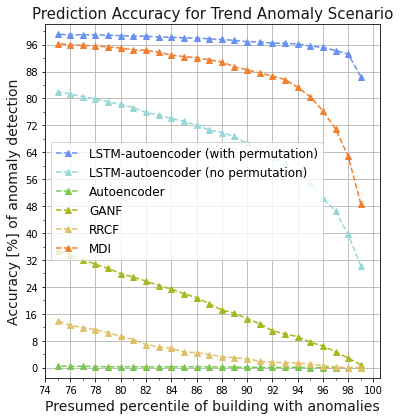

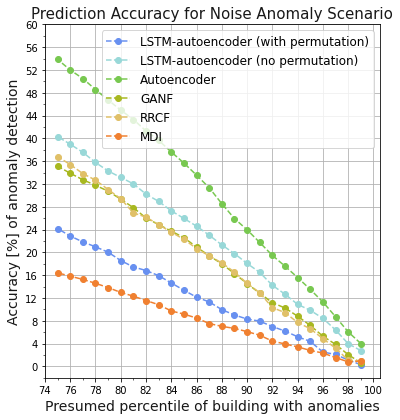

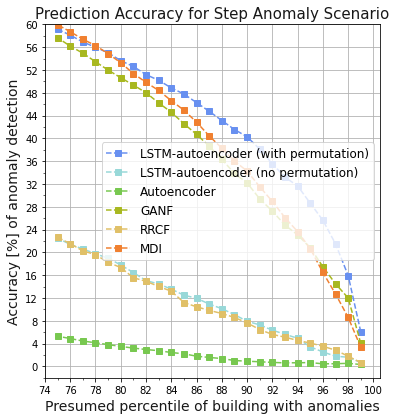

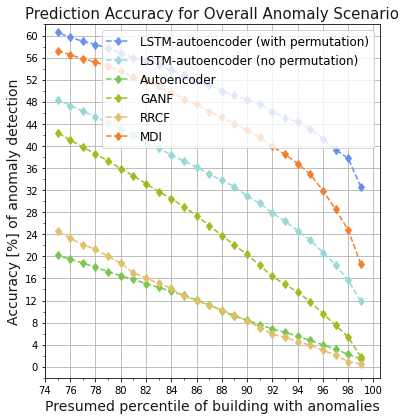

In [20]:
legend_list=["LSTM-autoencoder (with permutation)","LSTM-autoencoder (no permutation)","Autoencoder","GANF","RRCF", "MDI"]
y_set_list=[[-3,102],[-2,60],[-2,60],[-2,62]]
grid_list=[8,4,4,4]
df_list=[df_org_sw_org_lstm_pn_dtw, df_org_sw_org_lstm_n_dtw,df_org_ae_7_dtw,df_org_ganf_7,df_org_rrcf_7,df_org_md_7]
plot_comparative_accuracy("building", legend_list, df_list,y_set_list,grid_list,"comp_1")

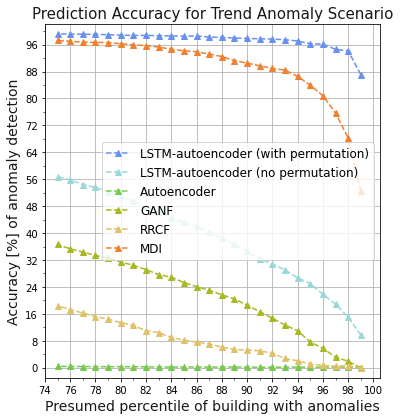

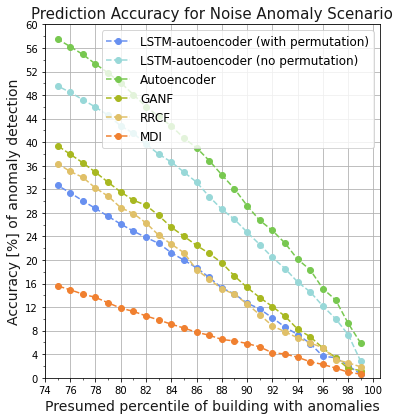

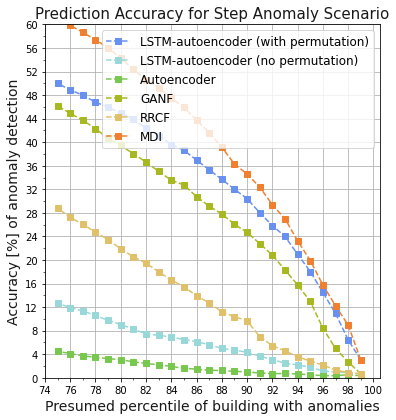

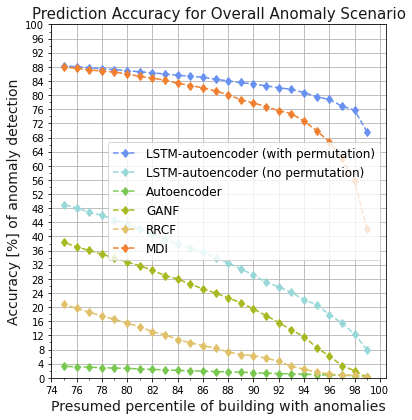

In [80]:
legend_list=["LSTM-autoencoder (with permutation)","LSTM-autoencoder (no permutation)","Autoencoder","GANF","RRCF", "MDI"]
y_set_list=[[-3,102],[-0,60],[-0,60],[0,100]]
grid_list=[8,4,4,4]
df_list=[df_org_dtw_p_5, df_org_dtw_5,df_org_ae_5_dtw,df_org_ganf_5,df_org_rrcf_5,df_org_md_5]
plot_comparative_accuracy("building", legend_list, df_list,y_set_list,grid_list,"comp_2")

In [21]:
#print(df_org_md_5.iloc[[24,9,1]])
#print(df_org_rrcf_5.iloc[[24,9,1]])
#print(df_org_ganf_5.iloc[[24,9,1]])
#print(df_org_ae_5_dtw.iloc[[24,9,1]])
#print(df_org_dtw_5.iloc[[24,9,1]])
print(df_org_md_7.iloc[[24,9,1]])
print(df_org_rrcf_7.iloc[[24,9,1]])
print(df_org_ganf_7.iloc[[24,9,1]])
print(df_org_ae_7_dtw.iloc[[24,9,1]])
print(df_org_sw_org_lstm_pn_dtw.iloc[[24,9,1]])
print(df_org_sw_org_lstm_n_dtw.iloc[[24,9,1]])
print(df_org_sw_org_lstm_pn_l1.iloc[[24,9,1]])
print(df_org_sw_org_lstm_n_l1.iloc[[24,9,1]])

    step_array  trend_acc  noise_acc  step_acc  overall_acc  weighted_acc
24        75.0   0.963105   0.164232  0.599468     0.572559      0.870929
9         90.0   0.884992   0.061020  0.342739     0.428125      0.761498
1         98.0   0.628752   0.007974  0.086022     0.248075      0.512898
    step_array  trend_acc  noise_acc  step_acc  overall_acc  weighted_acc
24        75.0   0.140121   0.368141  0.226566     0.245909      0.163481
9         90.0   0.026509   0.145725  0.076349     0.083231      0.039512
1         98.0   0.000000   0.011164  0.017921     0.009351      0.003471
    step_array  trend_acc  noise_acc  step_acc  overall_acc  weighted_acc
24        75.0   0.347782   0.351362  0.576750     0.424021      0.386843
9         90.0   0.146003   0.145323  0.321992     0.203454      0.175895
1         98.0   0.028436   0.020734  0.120072     0.053905      0.043721
    step_array  trend_acc  noise_acc  step_acc  overall_acc  weighted_acc
24        75.0   0.004435   0.538689  

**PLOT SMOOTHING EFFECT**

In [22]:
directory="/p/project/hai_eo_tree/kuzu/represent/represent_dlr/UC3/results/ed_sw/"
org_sw_1=directory+"1/ls_1_lt_dtw_lr_5e-05_pr_0_sw_1_in_True_id_False_ip_True_ed_32_tn_7_prediction_results_organic_final.csv"
syn_sw_1=directory+"1/ls_1_lt_dtw_lr_5e-05_pr_0_sw_1_in_True_id_False_ip_True_ed_32_tn_7_prediction_results_synthetic_final.csv"
org_sw_2=directory+"2/ls_1_lt_dtw_lr_0.001_pr_0_sw_3_in_True_id_False_ip_True_ed_32_tn_3_prediction_results_organic_final.csv"
syn_sw_2=directory+"2/ls_1_lt_dtw_lr_0.001_pr_0_sw_3_in_True_id_False_ip_True_ed_32_tn_3_prediction_results_synthetic_final.csv"
org_sw_3=directory+"3/ls_1_lt_dtw_lr_0.0005_pr_0_sw_5_in_True_id_False_ip_True_ed_32_tn_9_prediction_results_organic_final.csv"
syn_sw_3=directory+"3/ls_1_lt_dtw_lr_0.0005_pr_0_sw_5_in_True_id_False_ip_True_ed_32_tn_9_prediction_results_synthetic_final.csv"
org_sw_4=directory+"4/ls_1_lt_dtw_lr_0.001_pr_0_sw_7_in_True_id_False_ip_True_ed_32_tn_5_prediction_results_organic_final.csv"
syn_sw_4=directory+"4/ls_1_lt_dtw_lr_0.001_pr_0_sw_7_in_True_id_False_ip_True_ed_32_tn_5_prediction_results_synthetic_final.csv"
org_sw_5=directory+"5/ls_1_lt_dtw_lr_0.0005_pr_0_sw_9_in_True_id_False_ip_True_ed_32_tn_8_prediction_results_organic_final.csv"
syn_sw_5=directory+"5/ls_1_lt_dtw_lr_0.0005_pr_0_sw_9_in_True_id_False_ip_True_ed_32_tn_8_prediction_results_synthetic_final.csv"
org_sw_6=directory+"6/ls_1_lt_dtw_lr_0.001_pr_0_sw_11_in_True_id_False_ip_True_ed_32_tn_6_prediction_results_organic_final.csv"
syn_sw_6=directory+"6/ls_1_lt_dtw_lr_0.001_pr_0_sw_11_in_True_id_False_ip_True_ed_32_tn_6_prediction_results_synthetic_final.csv"
org_sw_7=directory+"7/ls_1_lt_dtw_lr_0.0005_pr_0_sw_13_in_True_id_False_ip_True_ed_32_tn_10_prediction_results_organic_final.csv"
syn_sw_7=directory+"7/ls_1_lt_dtw_lr_0.0005_pr_0_sw_13_in_True_id_False_ip_True_ed_32_tn_10_prediction_results_synthetic_final.csv"



In [23]:
df_org_sw_1, index_1, _=anomaly_score_reports(pd.read_csv(org_sw_1),pd.read_csv(syn_sw_1),min_percentile=74, step_resolution=1, anomaly_precision=0.0,per_building=True)
df_org_sw_2, index_2, _=anomaly_score_reports(pd.read_csv(org_sw_2),pd.read_csv(syn_sw_2),min_percentile=74, step_resolution=1, anomaly_precision=0.0,per_building=True)
df_org_sw_3, index_3, _=anomaly_score_reports(pd.read_csv(org_sw_3),pd.read_csv(syn_sw_3),min_percentile=74, step_resolution=1, anomaly_precision=0.0,per_building=True)
df_org_sw_4, index_4, _=anomaly_score_reports(pd.read_csv(org_sw_4),pd.read_csv(syn_sw_4),min_percentile=74, step_resolution=1, anomaly_precision=0.0,per_building=True)
df_org_sw_5, index_5, _=anomaly_score_reports(pd.read_csv(org_sw_5),pd.read_csv(syn_sw_5),min_percentile=74, step_resolution=1, anomaly_precision=0.0,per_building=True)
df_org_sw_6, index_6, _=anomaly_score_reports(pd.read_csv(org_sw_6),pd.read_csv(syn_sw_6),min_percentile=74, step_resolution=1, anomaly_precision=0.0,per_building=True)
df_org_sw_7, index_7, _=anomaly_score_reports(pd.read_csv(org_sw_7),pd.read_csv(syn_sw_7),min_percentile=74, step_resolution=1, anomaly_precision=0.0,per_building=True)


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

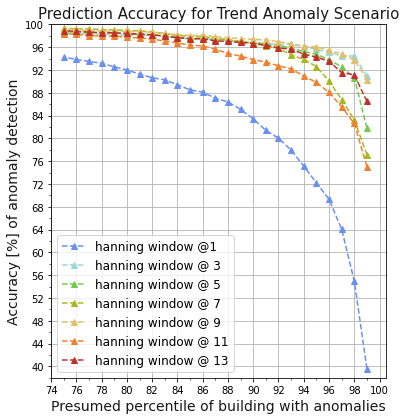

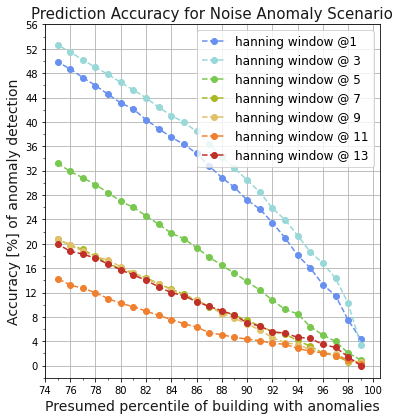

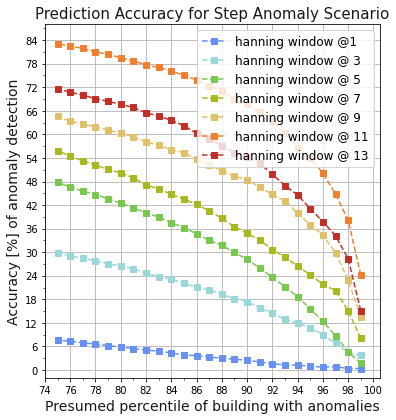

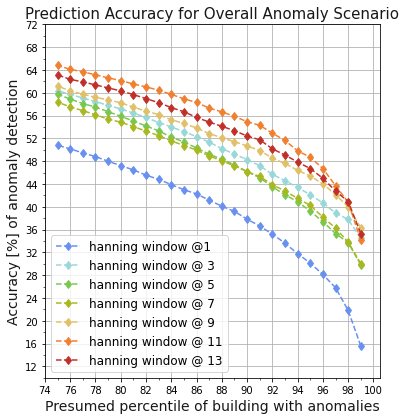

In [32]:
#plot_anomaly_accuracy("PSP", df_org_sw_1, index_1,"trial")
legend_list=["hanning window @1","hanning window @ 3","hanning window @ 5","hanning window @ 7","hanning window @ 9","hanning window @ 11","hanning window @ 13"]
y_set_list=[[38,100],[-2,56],[-2,88],[10,72]]
grid_list=[4,4,6,4]
df_list=[df_org_sw_1,df_org_sw_2,df_org_sw_3,df_org_sw_4,df_org_sw_5,df_org_sw_6,df_org_sw_7]
plot_comparative_accuracy("building", legend_list, df_list,y_set_list,grid_list,"window_effect")

**PLOT EMBEDDING EFFECT**

In [ ]:
directory="/p/project/hai_eo_tree/kuzu/represent/represent_dlr/UC3/results/ed_sw/"
org_sw_8=directory+"8/ls_1_lt_dtw_lr_0.001_pr_0_sw_5_in_True_id_False_ip_True_ed_1_tn_1_prediction_results_organic_final.csv"
syn_sw_8=directory+"8/ls_1_lt_dtw_lr_0.001_pr_0_sw_5_in_True_id_False_ip_True_ed_1_tn_1_prediction_results_synthetic_final.csv"
org_sw_9=directory+"9/ls_1_lt_dtw_lr_0.001_pr_0_sw_5_in_True_id_False_ip_True_ed_2_tn_4_prediction_results_organic_final.csv"
syn_sw_9=directory+"9/ls_1_lt_dtw_lr_0.001_pr_0_sw_5_in_True_id_False_ip_True_ed_2_tn_4_prediction_results_synthetic_final.csv"
org_sw_10=directory+"10/ls_1_lt_dtw_lr_0.001_pr_0_sw_5_in_True_id_False_ip_True_ed_4_tn_1_prediction_results_organic_final.csv"
syn_sw_10=directory+"10/ls_1_lt_dtw_lr_0.001_pr_0_sw_5_in_True_id_False_ip_True_ed_4_tn_1_prediction_results_synthetic_final.csv"
org_sw_11=directory+"11/ls_1_lt_dtw_lr_0.0005_pr_0_sw_5_in_True_id_False_ip_True_ed_8_tn_8_prediction_results_organic_final.csv"
syn_sw_11=directory+"11/ls_1_lt_dtw_lr_0.0005_pr_0_sw_5_in_True_id_False_ip_True_ed_8_tn_8_prediction_results_synthetic_final.csv"
org_sw_12=directory+"12/ls_1_lt_dtw_lr_0.001_pr_0_sw_5_in_True_id_False_ip_True_ed_16_tn_5_prediction_results_organic_final.csv"
syn_sw_12=directory+"12/ls_1_lt_dtw_lr_0.001_pr_0_sw_5_in_True_id_False_ip_True_ed_16_tn_5_prediction_results_synthetic_final.csv"
org_sw_13=directory+"13/ls_1_lt_dtw_lr_0.001_pr_0_sw_5_in_True_id_False_ip_True_ed_32_tn_0_prediction_results_organic_final.csv"
syn_sw_13=directory+"13/ls_1_lt_dtw_lr_0.001_pr_0_sw_5_in_True_id_False_ip_True_ed_32_tn_0_prediction_results_synthetic_final.csv"
org_sw_14=directory+"14/ls_1_lt_dtw_lr_0.0001_pr_0_sw_5_in_True_id_False_ip_True_ed_64_tn_11_prediction_results_organic_final.csv"
syn_sw_14=directory+"14/ls_1_lt_dtw_lr_0.0001_pr_0_sw_5_in_True_id_False_ip_True_ed_64_tn_11_prediction_results_synthetic_final.csv"



In [ ]:
df_org_sw_8, index_8, _=anomaly_score_reports(pd.read_csv(org_sw_8),pd.read_csv(syn_sw_8),min_percentile=74, step_resolution=1, anomaly_precision=0.0,per_building=True)
df_org_sw_9, index_9, _=anomaly_score_reports(pd.read_csv(org_sw_9),pd.read_csv(syn_sw_9),min_percentile=74, step_resolution=1, anomaly_precision=0.0,per_building=True)
df_org_sw_10, index_10, _=anomaly_score_reports(pd.read_csv(org_sw_10),pd.read_csv(syn_sw_10),min_percentile=74, step_resolution=1, anomaly_precision=0.0,per_building=True)
df_org_sw_11, index_11, _=anomaly_score_reports(pd.read_csv(org_sw_11),pd.read_csv(syn_sw_11),min_percentile=74, step_resolution=1, anomaly_precision=0.0,per_building=True)
df_org_sw_12, index_12, _=anomaly_score_reports(pd.read_csv(org_sw_12),pd.read_csv(syn_sw_12),min_percentile=74, step_resolution=1, anomaly_precision=0.0,per_building=True)
df_org_sw_13, index_13, _=anomaly_score_reports(pd.read_csv(org_sw_13),pd.read_csv(syn_sw_13),min_percentile=74, step_resolution=1, anomaly_precision=0.0,per_building=True)
df_org_sw_14, index_14, _=anomaly_score_reports(pd.read_csv(org_sw_14),pd.read_csv(syn_sw_14),min_percentile=74, step_resolution=1, anomaly_precision=0.0,per_building=True)


In [ ]:
#plot_anomaly_accuracy("PSP", df_org_sw_1, index_1,"trial")
legend_list=["embedding dimension @1","embedding dimension @ 2","embedding dimension @ 4","embedding dimension @ 8","embedding dimension @ 16","embedding dimension @ 32","embedding dimension @ 64"]
y_set_list=[[-3,101.9],[-2,40],[-1,59],[-3,101]]
grid_list=[7,3,4,7]
df_list=[df_org_sw_8,df_org_sw_9,df_org_sw_10,df_org_sw_11,df_org_sw_12,df_org_sw_13,df_org_sw_14]
plot_comparative_accuracy("building", legend_list, df_list,y_set_list,grid_list,"embedding_effect")

**PLOT PERMUTING AND LOSS EFFECT**

In [28]:
directory="/p/project/hai_eo_tree/kuzu/represent/represent_dlr/UC3/results/lstm/"
org_dtw_p=directory+"1/ls_1_lt_dtw_lr_0.0005_pr_0_sw_5_in_True_id_False_ip_True_ed_32_tn_4_prediction_results_organic_final.csv"
syn_dtw_p=directory+"1/ls_1_lt_dtw_lr_0.0005_pr_0_sw_5_in_True_id_False_ip_True_ed_32_tn_4_prediction_results_synthetic_final.csv"
org_dtw=directory+"6/ls_1_lt_dtw_lr_5e-05_pr_0_sw_5_in_True_id_False_ip_False_ed_32_tn_1_prediction_results_organic_final.csv"
syn_dtw=directory+"6/ls_1_lt_dtw_lr_5e-05_pr_0_sw_5_in_True_id_False_ip_False_ed_32_tn_1_prediction_results_synthetic_final.csv"
org_l1_p=directory+"11/ls_1_lt_l1_lr_0.0005_pr_0_sw_5_in_True_id_False_ip_True_ed_32_tn_2_prediction_results_organic_final.csv"
syn_l1_p=directory+"11/ls_1_lt_l1_lr_0.0005_pr_0_sw_5_in_True_id_False_ip_True_ed_32_tn_2_prediction_results_synthetic_final.csv"
org_l1=directory+"16/ls_1_lt_l1_lr_5e-05_pr_0_sw_5_in_True_id_False_ip_False_ed_32_tn_7_prediction_results_organic_final.csv"
syn_l1=directory+"16/ls_1_lt_l1_lr_5e-05_pr_0_sw_5_in_True_id_False_ip_False_ed_32_tn_7_prediction_results_synthetic_final.csv"

In [29]:
df_org_dtw_p, index_dtwp, _=anomaly_score_reports(pd.read_csv(org_dtw_p),pd.read_csv(syn_dtw_p),min_percentile=74, step_resolution=1, anomaly_precision=0.0,per_building=True)
df_org_dtw, index_dtw, _=anomaly_score_reports(pd.read_csv(org_dtw),pd.read_csv(syn_dtw),min_percentile=74, step_resolution=1, anomaly_precision=0.0,per_building=True)
df_org_l1_p, index_l1_p, _=anomaly_score_reports(pd.read_csv(org_l1_p),pd.read_csv(syn_l1_p),min_percentile=74, step_resolution=1, anomaly_precision=0.0,per_building=True)
df_org_l1, index_l1, _=anomaly_score_reports(pd.read_csv(org_l1),pd.read_csv(syn_l1),min_percentile=74, step_resolution=1, anomaly_precision=0.0,per_building=True)


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

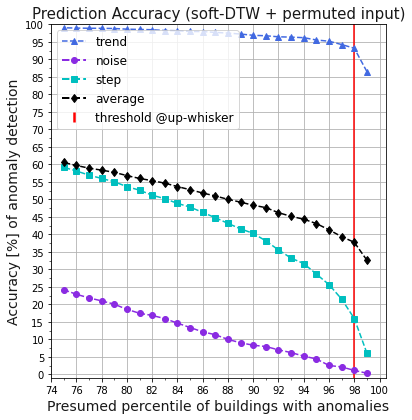

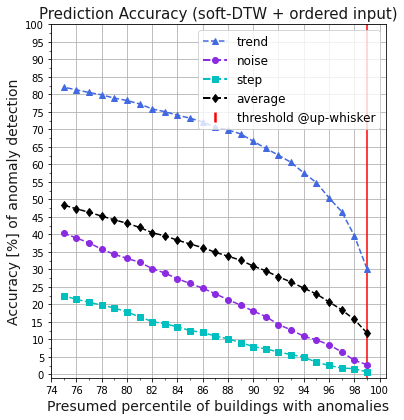

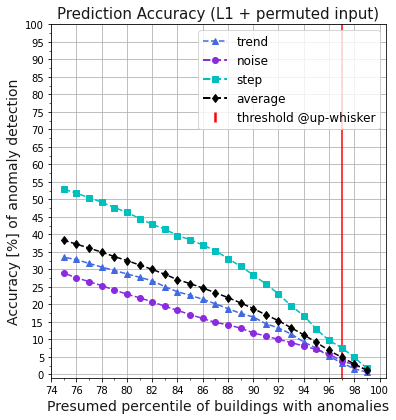

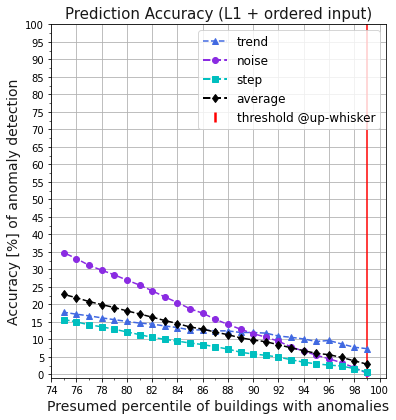

In [33]:
plot_anomaly_accuracy("buildings", df_org_sw_org_lstm_pn_dtw, index_pn_dtw, "(soft-DTW + permuted input)","dtw_p")
plot_anomaly_accuracy("buildings", df_org_sw_org_lstm_n_dtw, index_n_dtw, "(soft-DTW + ordered input)","dtw")
plot_anomaly_accuracy("buildings", df_org_sw_org_lstm_pn_l1, index_pn_l1,"(L1 + permuted input)","l1_p")
plot_anomaly_accuracy("buildings", df_org_sw_org_lstm_n_l1, index_n_l1,"(L1 + ordered input)","l1")


In [86]:
df_org_sw_org_lstm_pn_dtw

,step_array,trend_acc,noise_acc,step_acc,overall_acc,weighted_acc
0,99.0,0.865103,0.003086,0.060403,0.326064,0.695547
1,98.0,0.932070,0.011164,0.159498,0.377338,0.765738
2,97.0,0.942568,0.020971,0.214964,0.393399,0.783854
3,96.0,0.952091,0.025217,0.256341,0.412992,0.798592
4,95.0,0.955587,0.043822,0.286353,0.430855,0.807171
5,94.0,0.962206,0.051988,0.316667,0.443335,0.817876
6,93.0,0.963796,0.062028,0.332018,0.451477,0.822127
7,92.0,0.964706,0.069913,0.355533,0.461954,0.827144
8,91.0,0.967699,0.079400,0.381275,0.476402,0.834252
9,90.0,0.969005,0.083099,0.402905,0.483340,0.839103


**PLOT COMPARATIVE ACCURACY**

In [ ]:
directory="/p/project/hai_eo_tree/kuzu/represent/represent_dlr/UC3/results/graph/parameter_search/"
org_dtw_pg=directory+"ls_1_lt_dtw_lr_0.001_pr_0_sw_5_in_True_id_False_ip_True_ed_32_gh_8_gl_2_tn_2_prediction_results_organic_final.csv"
syn_dtw_pg=directory+"ls_1_lt_dtw_lr_0.001_pr_0_sw_5_in_True_id_False_ip_True_ed_32_gh_8_gl_2_tn_2_prediction_results_synthetic_final.csv"
df_org_dtw_pg, index_dtwpg, _=anomaly_score_reports(pd.read_csv(org_dtw_pg),pd.read_csv(syn_dtw_pg),min_percentile=74, step_resolution=1, anomaly_precision=0.0,per_building=True)

In [ ]:
legend_list=["LSTM autoencoder","GNN-LSTM autoencoder"]
y_set_list=[[72,100],[-2,40],[-1,59],[60,90]]
grid_list=[2,3,4,2]
df_list=[df_org_dtw_p,df_org_dtw_pg]
plot_comparative_accuracy("building", legend_list, df_list,y_set_list,grid_list,"lstm_compare")

**PLOT DENSITY**

In [ ]:
plot_anomaly_density(df_results_organic,df_results_synthetic,hist_bin=100,clip=4000)

**PLOT RECONSTRUCTION**

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline  

def plot_reconstruction(output, to_be_tested,performance,test_name,DERIVATIVE):
    IDX=[0,5,-6,-1]
    fig, axs = plt.subplots(nrows=2,ncols=1,sharey=False,sharex=True,figsize=(5, 8))
    fig.add_subplot(111, frameon=False)

    axs[0].plot(output[IDX[0],:,DERIVATIVE].ravel(), color="red")
    axs[0].plot(to_be_tested[IDX[0],:,DERIVATIVE].ravel(), color="black")
    axs[0].legend(["Predicted PS", "Observed PS"],prop={'size': 12})#loc='any left'
    axs[0].grid()
    axs[0].set_title("Non-anomalous Reconstruction")
    #axs[0,0].set_ylim([-3, 3])

    #axs[1].plot(output[IDX[1],:,DERIVATIVE].ravel(), color="red")
    #axs[1].plot(to_be_tested[IDX[1],:,DERIVATIVE].ravel(), color="black")
    #axs[1].legend(["Predicted PS", "Observed PS"],prop={'size': 12})#loc='any left'
    #axs[1].grid()
    #axs[1].set_title("Ordered Input + DTW Loss")
    #axs[0,1].set_ylim([-3, 3])



    #axs[2].plot(output[IDX[2],:,DERIVATIVE].ravel(), color="red")
    #axs[2].plot(to_be_tested[IDX[2],:,DERIVATIVE].ravel(), color="black")
    #axs[2].legend(["Predicted PS", "Observed PS"],prop={'size': 12})#loc='any left'
    #axs[2].grid()
    ##axs[2].set_title("Permuted Input + L1 Loss")
    ##axs[1,0].set_ylim([-3, 3])


    axs[1].plot(output[IDX[3],:,DERIVATIVE].ravel(), color="red")
    axs[1].plot(to_be_tested[IDX[3],:,DERIVATIVE].ravel(), color="black")
    axs[1].legend(["Predicted PS", "Observed PS"],prop={'size': 12})#loc='any left'
    axs[1].grid()
    axs[1].set_title("Anomalous Reconstruction")
    #axs[1,1].set_ylim([-3, 3])
    plt.title("Accuracy {}".format(performance),size = 15,alpha=0.9)
    #ax.legend(legend_element, ["PS instance for {} anomaly".format(label_names[ANOMALY])],prop={'size': 12})
    #plt.xlabel('time stamps (years 2015 - 2020)',size = 14,alpha=0.9,labelpad=20)
    #plt.axis('off')
    plt.xticks([])
    plt.yticks([])
    plt.ylabel('displacement along LOS (mm)',size = 14,alpha=0.9,labelpad=25)
    fig.savefig('temp/accuracy_{}_{}_{}.png'.format(performance,test_name,DERIVATIVE),dpi=300,bbox_inches='tight')

In [2]:
import torch
import pandas as pd
import numpy as np
from src.data_loader import Dataloader
from src.lstm_autoencoder import RecurrentAutoencoder
from glob import glob

directory="/p/project/hai_eo_tree/kuzu/represent/represent_dlr/UC3/results/lstm/"

LR=[0.0001, 1e-05]
PR=[0.1,0.01,0.001]
NORM=[False]
PERMUTE=[False]
GRADIENT=[True]
GAMMA=[0.1,0.5,1.0,5.0,10.0]

DEVICE='cpu'
for Ni in NORM:
    for Pi in PERMUTE:
        for Gri in GRADIENT:
            if True: data_loader = Dataloader("data/database_train.csv",
                                 'data/database_test.csv',
                                 'data/valdataset_3_3_3.csv',
                                  split=0.25,
                                  batch_size=4,
                                  window_length=7,
                                  num_workers=2,
                                  is_normalize=Ni,
                                  is_detrend=False,
                                  is_permute=Pi,
                                  is_gradient=Gri,
                                  is_debug=False,
                                  seed=42)
            for LRi in LR:
                for PRi in PR:
                    for Gi in GAMMA:
                        test_name="ls_1_lt_dtw_lr_{}_pr_{}_sw_7_in_{}_id_False_ip_{}_ig_{}_ed_32_gm_{}_tn_0".format(LRi,PRi,Ni,Pi,Gri,Gi)
                        print(test_name)
                        model_dir=directory+"28/{}_model_best.pth.tar".format(test_name)
                        org_sw=directory+"28/{}_prediction_results_organic_final.csv".format(test_name)
                        result_name=directory+"28/{}_*prediction_report_final.csv".format(test_name)
                        try:
                            #print(performance=glob(result_name)[0].split("_"))
                            performance=glob(result_name)[0].split("_")[-6]
                            pds=pd.read_csv(org_sw)
                            pds=pds.sort_values(by=['loss'], ascending=True)
                            test_indices =np.concatenate([pds.unique_id.values[10:20],pds.unique_id.values[-101:-91]])
                            #continue

                        except Exception as e:
                            print(e)
                            continue


                        model = RecurrentAutoencoder(data_loader.get_data_dimensions()[0], data_loader.get_data_dimensions()[-1], 32)
                        model.load_state_dict(torch.load(model_dir,DEVICE))
                        model.to(DEVICE)
                        model.eval()

                        test_array=data_loader.get_test_array()
                        test_array=np.transpose(test_array, (1, 0, 2))
                        to_be_tested=test_array[test_indices,:,:]
                        output=model(torch.from_numpy(to_be_tested).to(DEVICE).float())
                        output=output.detach().cpu().numpy()
                        plot_reconstruction(output, to_be_tested,performance,test_name,0)
                        #if output.shape[-1]>1:
                        #    plot_reconstruction(output, to_be_tested,performance,test_name,1)
                        #    plot_reconstruction(output, to_be_tested,performance,test_name,2)


                


ModuleNotFoundError: No module named 'tslearn'

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline  

IDX=10
fig, axs = plt.subplots(nrows=2,ncols=2,sharey=False,sharex=True,figsize=(14, 6))
fig.add_subplot(111, frameon=False)

axs[0,0].plot(output_1[IDX,:,:].ravel(), color="red")
axs[0,0].plot(to_be_tested[IDX,:,:].ravel(), color="black")
axs[0,0].legend(["Predicted PS", "Observed PS"],prop={'size': 12})#loc='any left'
axs[0,0].grid()
axs[0,0].set_title("Permuted Input + DTW Loss")

axs[0,1].plot(output_2[IDX,:,:].ravel(), color="red")
axs[0,1].plot(to_be_tested[IDX,:,:].ravel(), color="black")
axs[0,1].legend(["Predicted PS", "Observed PS"],prop={'size': 12})#loc='any left'
axs[0,1].grid()
axs[0,1].set_title("Ordered Input + DTW Loss")


axs[1,0].plot(output_3[IDX,:,:].ravel(), color="red")
axs[1,0].plot(to_be_tested[IDX,:,:].ravel(), color="black")
axs[1,0].legend(["Predicted PS", "Observed PS"],prop={'size': 12})#loc='any left'
axs[1,0].grid()
axs[1,0].set_title("Permuted Input + L1 Loss")

axs[1,1].plot(output_4[IDX,:,:].ravel(), color="red")
axs[1,1].plot(to_be_tested[IDX,:,:].ravel(), color="black")
axs[1,1].legend(["Predicted PS", "Observed PS"],prop={'size': 12})#loc='any left'
axs[1,1].grid()
axs[1,1].set_title("Ordered Input + L1 Loss")

In [1]:
from src.data_loader import Dataloader
import pandas as pd
import numpy as np
from maxdiv import *
from rrcf import rrcf

In [2]:
data_loader = Dataloader("data/database_train.csv",
                                 'data/database_test.csv',
                                 'data/valdataset_3_3_3.csv',
                                  split=0.25,
                                  batch_size=4,
                                  window_length=7,
                                  num_workers=2,
                                  is_normalize=False,
                                  is_detrend=False,
                                  is_permute=False,
                                  is_gradient=False,
                                  is_debug=True,
                                  seed=42)

In [8]:
test_array=data_loader.get_test_array()

In [10]:
np.transpose(test_array,(1,0,2))[:,:,-1].shape

(1024, 299)

**NON-STABLE EXPERIMENTAL**

In [23]:
d=maxdiv.maxdiv(np.transpose(test_array,(1,0,2))[:1,:,-1])

/tmp/ipykernel_15954/3091800410.py:1: RuntimeWarning: libmaxdiv could not be loaded. Falling back to the Python implementation, but this will be much slower and results may be different.
  d=maxdiv.maxdiv(np.transpose(test_array,(1,0,2))[:1,:,-1])


In [19]:
def maxdiv_anomaly(data_array):
    
    for i in range (np.max(data_array.shape[])

[(279, 299, 11.096039676579869),
 (225, 245, 5.40631892202161),
 (149, 169, 4.115590953918411),
 (17, 37, 3.913544168967128),
 (177, 197, 3.690440477269605),
 (96, 116, 3.463988367711059),
 (45, 65, 3.1883124566734153),
 (65, 85, 2.63712728112169),
 (126, 146, 2.258235067274305),
 (201, 225, 2.0935000847911103),
 (257, 277, 2.057432706797236)]

In [24]:
d[0][-1]

3.463486781771639

In [5]:
data=np.transpose(test_array,(1,0,2))[:1,:,-1]

In [6]:
data.shape

(1, 299)

In [7]:
d=maxdiv.maxdiv(data)

/tmp/ipykernel_26808/2968627279.py:1: RuntimeWarning: libmaxdiv could not be loaded. Falling back to the Python implementation, but this will be much slower and results may be different.
  d=maxdiv.maxdiv(data)


In [15]:
tree.leaves

NameError: name 'tree' is not defined

In [44]:
rt=rrcf.RCTree(np.transpose(test_array,(1,0,2))[:,:,-1])

In [38]:
rt.insert_point(np.transpose(test_array,(1,0,2))[0:2,:,-1], index_labels=[0,1,2])

TypeError: insert_point() got an unexpected keyword argument 'index_labels'

In [59]:
rt.leaves

{821: Leaf(821),
 943: Leaf(943),
 930: Leaf(930),
 934: Leaf(934),
 368: Leaf(368),
 19: Leaf(19),
 683: Leaf(683),
 21: Leaf(21),
 267: Leaf(267),
 820: Leaf(820),
 920: Leaf(920),
 178: Leaf(178),
 932: Leaf(932),
 819: Leaf(819),
 407: Leaf(407),
 1001: Leaf(1001),
 413: Leaf(413),
 89: Leaf(89),
 124: Leaf(124),
 96: Leaf(96),
 303: Leaf(303),
 929: Leaf(929),
 62: Leaf(62),
 176: Leaf(176),
 142: Leaf(142),
 1016: Leaf(1016),
 598: Leaf(598),
 29: Leaf(29),
 595: Leaf(595),
 258: Leaf(258),
 604: Leaf(604),
 957: Leaf(957),
 175: Leaf(175),
 647: Leaf(647),
 423: Leaf(423),
 997: Leaf(997),
 83: Leaf(83),
 310: Leaf(310),
 799: Leaf(799),
 616: Leaf(616),
 318: Leaf(318),
 7: Leaf(7),
 224: Leaf(224),
 14: Leaf(14),
 1005: Leaf(1005),
 243: Leaf(243),
 227: Leaf(227),
 1011: Leaf(1011),
 955: Leaf(955),
 4: Leaf(4),
 327: Leaf(327),
 705: Leaf(705),
 938: Leaf(938),
 993: Leaf(993),
 13: Leaf(13),
 356: Leaf(356),
 562: Leaf(562),
 895: Leaf(895),
 731: Leaf(731),
 995: Leaf(995)

In [56]:
a=np.concatenate([np.asarray([rt.codisp(leaf) for leaf in rt.leaves])],0)

(array([991.,  18.,   9.,   0.,   3.,   0.,   0.,   0.,   1.,   2.]),
 array([1.000e+00, 1.028e+02, 2.046e+02, 3.064e+02, 4.082e+02, 5.100e+02,
        6.118e+02, 7.136e+02, 8.154e+02, 9.172e+02, 1.019e+03]),
 <BarContainer object of 10 artists>)

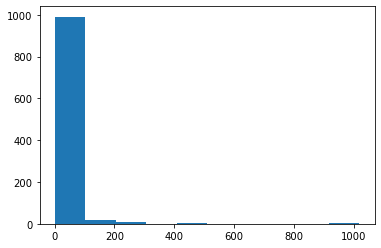

In [52]:
plt.hist(a)

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline  

In [61]:
rt.query(np.transpose(test_array,(1,0,2))[4,:,-1])

Leaf(4)

In [62]:
[np.asarray([rt.codisp(leaf) for leaf in rt.leaves])]

[array([1019.        ,   15.        ,    8.17117117, ...,  255.        ,
         255.        ,  255.        ])]